## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2023-12-15 14:21:57--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-15 14:21:58 (8.00 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [ ]:
print(text[:1000])


i

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
но, боже мой, какая скука
с больным сидеть и день и ночь,
не отходя ни шагу прочь!
какое низкое коварство
полуживого забавлять,
ему подушки поправлять,
печально подносить лекарство,
вздыхать и думать про себя:
когда же черт возьмет тебя!»



ii

так думал молодой повеса,
летя в пыли на почтовых,
всевышней волею зевеса
наследник всех своих родных. —
друзья людмилы и руслана!
с героем моего романа
без предисловий, сей же час
позвольте познакомить вас:
онегин, добрый мой приятель,
родился на брегах невы,
где, может быть, родились вы
или блистали, мой читатель;
там некогда гулял и я:
но вреден север для меня


iii

служив отлично-благородно,
долгами жил его отец,
давал три бала ежегодно
и промотался наконец.
судьба евгения хранила:
сперва madame за ним ходила,
потом monsieur ее сменил;
ребенок был резов, но мил.
monsieur l’abbe€, француз убогой,
чтоб не и

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 59, 62, ..., 50, 58, 73],
       [83, 55, 53, ..., 46, 50, 62],
       [83, 50, 49, ..., 56, 53,  1],
       ...,
       [83, 49, 58, ..., 59, 48,  2],
       [83,  0,  0, ..., 58, 50, 49],
       [83, 59, 62, ..., 45, 62,  5]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
class RNN(nn.Module):
    def __init__(self, num_tokens, embed_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(num_tokens, embed_size)
        self.i2h = nn.Linear(embed_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, num_tokens)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = self.encoder(input)
        combined = torch.cat([input, hidden], dim=1)
        hidden = self.i2h(combined)
        hidden = torch.tanh(hidden)
        output = self.h2o(hidden)
        output = self.logsoftmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

In [ ]:
def rnn_loop(rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hidden = rnn.init_hidden(batch_size).to(device)
    logprobs = []

    for inp in batch_ix.transpose(0, 1):
        logp, hidden = rnn(inp, hidden)
        logprobs.append(logp)

    return torch.stack(logprobs, dim=1)

In [ ]:
embed_size=20
hidden_size=128

loss_func = nn.NLLLoss()
char_rnn = RNN(num_tokens, embed_size, hidden_size).to(device)

lr = 0.001
opt = torch.optim.Adam(char_rnn.parameters(), lr=lr)
history = []

n_epochs = 10000
print_every = 100

In [ ]:
def train(rnn, loss_func, n_epochs):
    for i in range(n_epochs):
        batch_ix = torch.tensor(next(generate_chunk()), dtype=torch.int64).to(device)

        logp_seq = rnn_loop(rnn, batch_ix)

        predictions_logp = logp_seq[:, :-1]
        target_tokens = batch_ix[:, 1:]

        loss = loss_func(
            predictions_logp.reshape(-1, num_tokens),
            target_tokens.reshape(-1))
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.cpu().numpy())
        if (i+1) % print_every == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()



In [ ]:
train(char_rnn, loss_func, n_epochs)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = char_rnn.init_hidden(1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hidden = char_rnn(x_sequence[:, i], hidden)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        output, hidden, = char_rnn(x_sequence[:, -1], hidden)
        p_next = torch.exp(output / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=250, temperature=0.8))

In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=250, temperature=0.5))

<sos> мой дядя самых честных правиляю до глупоком,
и в страшно я забово,
и сердце нас ничего страстей дом)
не вседсе слез воле
срод переб часто на полной
увяди думал: все на полный
и пестательных душою;
мне старельной на друга,
когда бы восповали мать.





In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=250, temperature=0.3))

<sos> мой дядя самых честных правиляютилскордость,
и в то в ольгин оденье,
и в души моей даляна,
не похот он не полный водой
достойный раз рукой,
надежды, полно бездор;
душа света и в собластвовал
страдает свой полемной
в окнем обще в нем сердце лет.



x


In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=250, temperature=0.1))

<sos> мой дядя самых честных правиляю тебя
она под неже твоетства,
как девический приводит
и в то в ольгин одна в ней страстей страсть
ее страстей страстью,
не все предальным сердце насладел
и в том сердце в темно привета
он под ней на своей полон.



xxx


In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=250, temperature=1))

<sos> мой дядя самых честных правиляенья;
да умы безбуждена хначенье;



xvii

«ну, как усы такор! —
будя, к жеркую то ж на страленья,
как друг небесных отцемен,
благойстал об ней кахляной
не обрасим одона
все я, тустя торарой
онегин с мал благойбокры,
он


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правиляюшь годо,
своин из другию убил невужает
и запели любви домой
уерделой, надрась превлелительницке
печейно время взоленный,
и следе я лево того подруг,
такбе смеет обожны, заляла,
но обновити читал ваши ли,
татьяна рося,
не раз рукой, пораким задол
приныло на свокло, хояда
сквеж певгенить подъемох представить
и наконец верила;
хоть так уставане велит,
как тем очитая друженья,
и радонянья сердце славшой,
в ней соседу кто мы е.



xxxvii

его старал задыва:
по вас ольг


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=0.8
    ).replace('<sos>', '')
    for _ in range(10)
]


In [ ]:
print(generated_phrases[0])

 мой дядя самых честных правилена
всегда ей всповедит мновом,
пустой молодой,
на вечер старика ромный,
не сплива и кажным слез,
и прандох посных из окилей
мне счуж не рад небут видит замервый порыва;
по толковейшины! бысловой,
на вотам сей стала доброй
слезы приятку отвычной
душа страх иль она с подрух;
старишке ж не уж байская тень
так на мало венерном
пред ниму вечер плакала,
хоть на него женточет,
любил большя всё трика
и забыл по волненья;
зарецт одохнакой моей.
поэт ей не глядит
симана полн


In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_tokens, embed_size, hidden_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(num_tokens, embed_size)
        self.lstm = nn.LSTMCell(embed_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, num_tokens)

    def forward(self, input, h, c):
        input = self.encoder(input)
        h, c = self.lstm(input, (h, c))
        output = self.decoder(h)
        return output, h, c

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

In [ ]:
def lstm_loop(rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    h = rnn.init_hidden(batch_size).to(device)
    c = rnn.init_hidden(batch_size).to(device)
    outputs = []

    for inp in batch_ix.transpose(0, 1):
        output, h, c = rnn(inp, h, c)
        outputs.append(output)

    return torch.stack(outputs, dim=1)

def lstm_train(rnn, loss_func, n_epochs):
    for i in range(n_epochs):
        batch_ix = torch.tensor(next(generate_chunk()), dtype=torch.int64).to(device)

        seq = lstm_loop(rnn, batch_ix)

        predictions_seq = seq[:, :-1]
        target_tokens = batch_ix[:, 1:]

        loss = loss_func(
            predictions_seq.reshape(-1, num_tokens),
            target_tokens.reshape(-1))
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.cpu().numpy())
        if (i+1) % print_every == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()



In [ ]:
embed_size=20
hidden_size=128

loss_func = nn.CrossEntropyLoss()
char_lstm = LSTM(num_tokens, embed_size, hidden_size)
char_lstm.to(device)

lr = 0.001
opt = torch.optim.Adam(char_lstm.parameters(), lr=lr)
history = []

n_epochs = 10000
print_every = 100

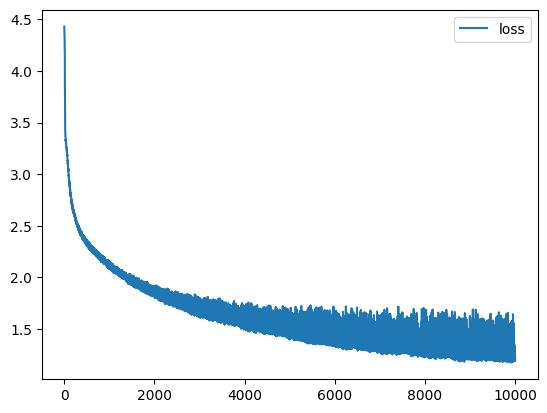

In [ ]:
lstm_train(char_lstm, loss_func, n_epochs)

In [ ]:
def lstm_generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    h = char_rnn.init_hidden(1).to(device)
    c = char_rnn.init_hidden(1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, h, c = char_rnn(x_sequence[:, i], h, c)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        output, h, c = char_rnn(x_sequence[:, -1], h, c)
        p_next = F.softmax(output / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
print(lstm_generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=250, temperature=0.8))

<sos> мой дядя самых честных правиладкий):
он не извета тихо, ть мой
в ее рожды, ручей одет
поступливий в дохвя разговы,
землала на чести покасны,
и заперкою мои толком;
всё бессуждены посланих.
за чудоваю льбом, как утвой
тревог и жар нет об,
тестих, как


In [ ]:
print(lstm_generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=250, temperature=0.2))

<sos> мой дядя самых честных правилядеть
меж тем дверь нас не постелелья,
и в деревню в постеле свойми
и забот и первый призвать.



xxxvi

вставай: все досуждено отворит,
и в коро, с толк в грандисона,
что нет ольгу ей нет она
два столь был подобно в сво


In [ ]:
print(lstm_generate_sample(char_lstm, ' мой дядя самых честных правил', max_length=250, temperature=0.000001))

<sos> мой дядя самых честных правилядеть,
порой разговой подвижальной
в сем сердце говорил с тобой.
приболвилась полон странный,
всегда волиненный потре,
сей понять в деревня в уноте,
и страшно здесь с покою: ночно
всё там ленью шевелась,
в глуши в страшн
